In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
def data_generator(sample_size: int,
                   err_val: int=None) -> pd.DataFrame:
    '''Создаем синтетический датасет'''

    feature_A = 20 * np.random.randn(sample_size) + 100
    feature_B = 30 * np.random.randn(sample_size) + 200
    feature_C = 5 * np.random.randn(sample_size) + 20

    result = 2 * feature_A \
             + 8 * feature_B \
             + feature_C \
             + 25 * np.random.randn(sample_size) + 30

    df = pd.DataFrame({
        'A': feature_A,
        'B': feature_B,
        'C': feature_C,
        'Y': result})

    if err_val:
        idx = np.random.randint(0, sample_size, round(sample_size * 0.1))
        df.loc[idx, 'B'] = df.loc[idx, 'B'] * err_val

    return df

**Создаем три датасета с качественными данными**

In [4]:
df_1 = data_generator(5000)
df_2 = data_generator(6000)
df_3 = data_generator(5000)

**Создаем один "косячный" датасет**

In [5]:
df_err = data_generator(3000, 2)

**Сохраняем выборки на диск**

In [7]:
df_1.to_csv('./dataset_1.csv', index=False)
df_2.to_csv('./dataset_2.csv', index=False)
df_3.to_csv('./dataset_3.csv', index=False)
df_err.to_csv('./dataset_err.csv', index=False)

**Рисуем один нормальный датасет**

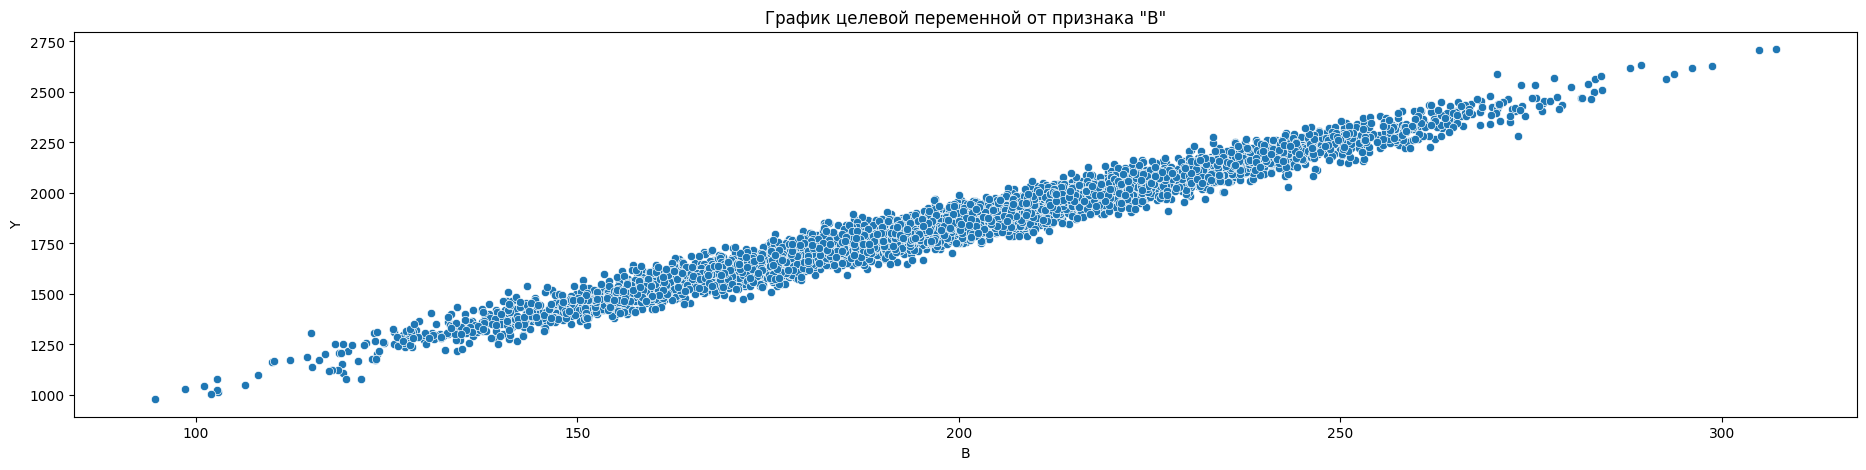

In [8]:
fig = plt.figure(figsize=(23, 5))

scat_plot = sns.scatterplot(data=df_2, 
                            x='B', 
                            y='Y');

scat_plot.set_title('График целевой переменной от признака "B"');

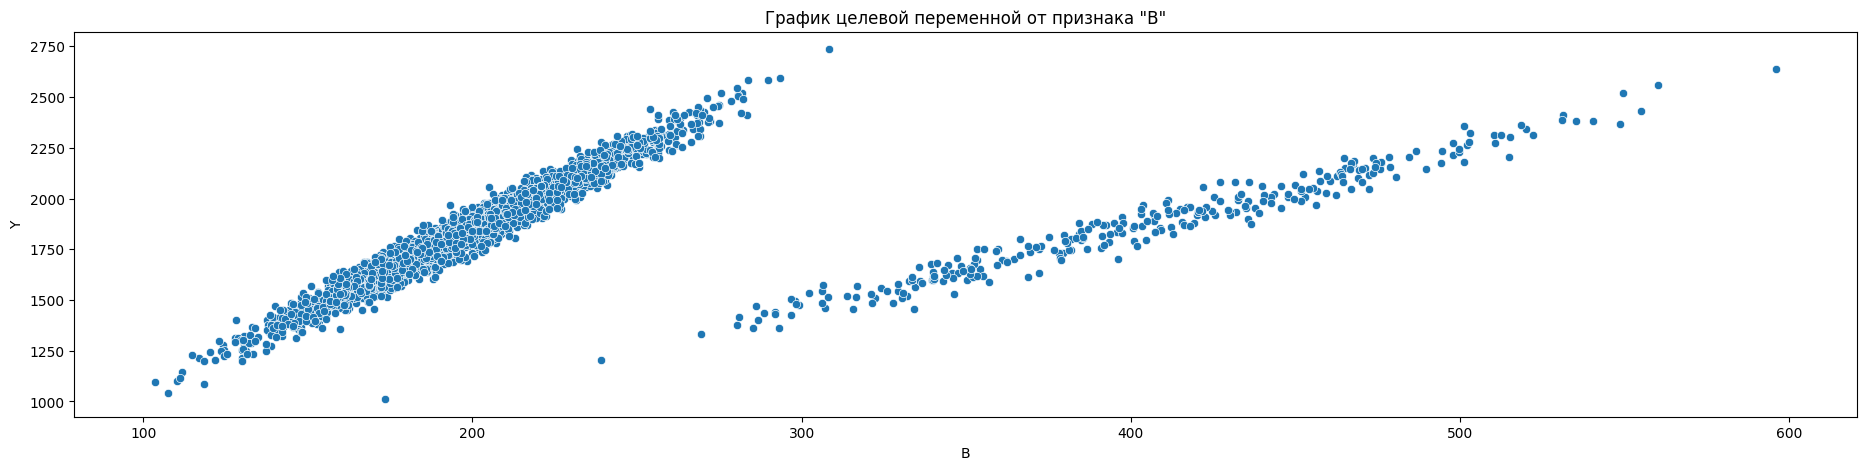

In [9]:
#err_dataset
fig = plt.figure(figsize=(23, 5))

scat_plot = sns.scatterplot(data=df_err, 
                            x='B', 
                            y='Y');

scat_plot.set_title('График целевой переменной от признака "B"');

    -Learning:

In [10]:
from sklearn.linear_model import LinearRegression

In [31]:
train_y = df_2['Y']
train_X = df_2.drop('Y', axis=1)

model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression()

In [13]:
#pkl_model
pkl_filename = 'model.pkl'
with open(pkl_filename, 'wb') as file_:
    pickle.dump(model, file_)

**Тестируем модель на датасете №№1, 3**

In [14]:
test_y = df_1['Y']
test_X = df_1.drop('Y', axis=1)

model.score(test_X, test_y)

0.9895175499214449

In [15]:
test_y = df_3['Y']
test_X = df_3.drop('Y', axis=1)

model.score(test_X, test_y)

0.989720057588222

**Пробуем метрику на "косячном" датасете (любопытства ради)**

In [16]:
test_y = df_err['Y']
test_X = df_err.drop('Y', axis=1)

model.score(test_X, test_y)

-3.269648995185558

        - Метрика == 0.98, чтобы всё, что ниже, не проходило тесты.

**Пробуем другие способы найти проблемы в датасете**

In [17]:
df_2.describe()

,A,B,C,Y
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,100.492781,199.059788,20.102734,1843.837062
std,20.236539,30.091730,4.981120,245.216199
min,27.419745,94.686239,1.467759,978.770038
25%,86.689511,178.698295,16.775260,1681.980109
50%,100.692803,199.060126,20.010160,1846.169242
75%,114.249737,219.445142,23.443264,2006.658326
max,172.971934,307.118969,40.073460,2711.391002


<AxesSubplot: xlabel='B', ylabel='Count'>

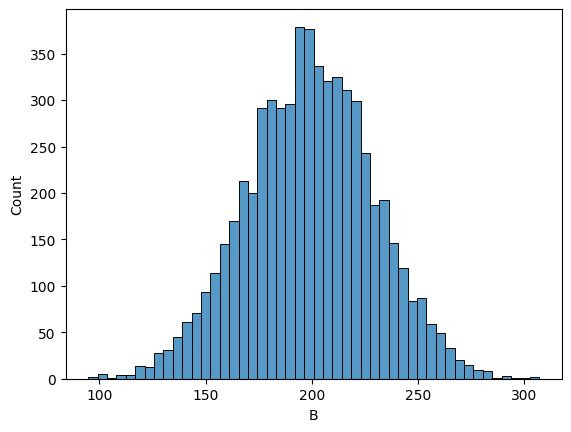

In [19]:
sns.histplot(df_2['B'])

In [20]:
df_err.describe()

,A,B,C,Y
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,100.071867,218.861248,20.053093,1847.117214
std,20.261954,69.414267,5.016789,244.796884
min,30.329912,103.706609,1.401237,1011.039440
25%,86.660214,180.889472,16.611253,1677.058247
50%,100.383095,204.293112,20.095021,1849.904406
75%,113.582142,227.302621,23.402073,2011.290826
max,174.288297,595.961638,38.309022,2735.923886


<AxesSubplot: xlabel='B', ylabel='Count'>

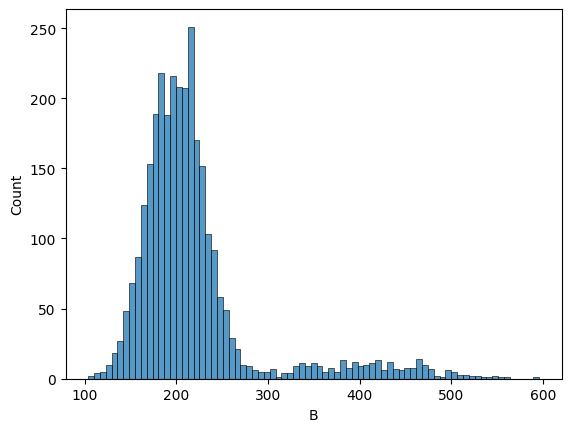

In [21]:
sns.histplot(df_err.B)

Созданный нами "косяк" лучше всего отследить через дисперсию и выбросы, чем через другие параметры распределения.

**Промежуточный вывод:**

Отлавливать ошибку будем:
1. Падением метрики по исследуемой выборке ниже 0.98;
2. Изменением параметра std выборки;
3. Можно также по изменению максимума/минимума

In [26]:
%%writefile 'test_datasets.py' 

import pytest
import os
import pandas as pd
import pickle


datasets = {}
files = os.listdir('./')
for df_file in files:
    if df_file.endswith('.csv'):
        print(df_file)
        datasets[df_file] = pd.read_csv(os.path.join('./', df_file))

pkl_filename = 'model.pkl'
with open(pkl_filename, 'rb') as file_:
    model = pickle.load(file_)



def test_metric_crash():
    '''Тестируем метрику'''
    for dataset in datasets:
        test_y = datasets[dataset]['Y']
        test_X = datasets[dataset].drop('Y', axis=1)
        assert model.score(test_X, test_y) > 0.98


def test_std():
    '''Тестируем дисперсию'''
    for dataset in datasets:
        assert datasets[dataset]['B'].std() < 50


def test_median():
    '''Тестируем медиану, чтобы хоть один тест прошёл для примера'''
    for dataset in datasets:
        assert 150 < datasets[dataset]['B'].median() < 300

Overwriting test_datasets.py


In [27]:
!pytest -v

**Удаляем "косячный" файл**

In [29]:
import os

os.remove('./dataset_err.csv')

**И снова запускаем pytest**

In [30]:
!pytest -v